# Evaluation of FLS Classifiers

This notebook evaluates the performance of the two FLS Classifiers trained from DistilBERT (``11a_fls-classifier_bert.ipynb``) and from FinBERT (``11b_fls-classifier_finbert.ipynb``). An unseen test set was used to make sure the comparability of the performance between these two classifiers. The test set was manually reviewed. 

## Import packages

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Load data

In [2]:
# Import test set
df = pd.read_csv('../../data/01_interim/test.csv')

In [3]:
df['Label'].value_counts()

0    45
1     7
Name: Label, dtype: int64

In [3]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce MX150


## Define function to test model

In [4]:
def test_model(model, tokenizer, test_data, batch_size=8, device="cuda"):
    # Input: model name, tokenizer name, test dataset, batch size, device (batch size and device are optional)
    # Output: mean accuracy, list of predictions, list of accuracies, list of labels
    
    
    # Load the model
    model = AutoModelForSequenceClassification.from_pretrained(model)
    # Load the tokenizer
    tokenizer = AutoTokenizer.from_pretrained(tokenizer, do_lower_case=True)
    # Tokenize all of the sentences and map the tokens to their word IDs
    text_encoded = [tokenizer.encode(sent,
                                    add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
                                    padding='max_length',  # Pad & truncate all sentences.
                                    truncation=True,
                                    max_length=512,
                                    ) for sent in test_data['Sentence']]

    # Data to tensors
    text_tensor = torch.tensor(text_encoded).to(device)
    labels_tensor = torch.tensor(test_data['Label'].values).to(device)

    # Create the DataLoader for the test set
    test_data = TensorDataset(text_tensor, labels_tensor)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    
    model.to(device)
    model.eval()
    accuracy_sum = 0
    preds_list = []
    accuracy_list = []
    labelsset = []

    with torch.no_grad():
        for batch in tqdm(test_dataloader):
            input_ids, labels = batch
            input_ids = input_ids.to(device)
            outputs = model(input_ids)
            logits = outputs.logits.detach().cpu().numpy()  # Taking the softmax of output
            pred = np.argmax(logits, axis=1).tolist()
            acc = accuracy_score(labels.detach().cpu().numpy().tolist(), pred)
            accuracy_sum += acc
            preds_list.extend(pred)
            accuracy_list.append(acc)
            labelsset.extend(labels.detach().cpu().numpy())

    mean_accuracy = accuracy_sum / len(test_dataloader)
    return mean_accuracy, preds_list, accuracy_list, labelsset

## Evalute results

Classification reports are used to evaluate the results on test set. 

In [8]:
# DistilBERT
print("Report on DistilBERT-FLS: \n")
_, pred_distilbert, _, labelsset = test_model('../../models/distilbert-fls', 'distilbert-base-uncased',df)

# FinBERT
print("Report on FinBERT-FLS: \n")
_, pred_finbert , _ , _ = test_model('../../model/finbert-fls', 'yiyanghkust/finbert-pretrain',df)

Report on DistilBERT-FLS: 



100%|██████████| 7/7 [00:00<00:00, 25.86it/s]


Report on FinBERT-FLS: 



100%|██████████| 7/7 [00:00<00:00, 14.01it/s]


In [9]:
# DistilBERT
print("Report on DistilBERT-FLS: \n")
print(classification_report(labelsset, pred_distilbert))

# FinBERT
print("Report on FinBERT-FLS: \n")
print(classification_report(labelsset, pred_finbert))


Report on DistilBERT-FLS: 

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        45
           1       0.71      0.71      0.71         7

    accuracy                           0.92        52
   macro avg       0.83      0.83      0.83        52
weighted avg       0.92      0.92      0.92        52

Report on FinBERT-FLS: 

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        45
           1       0.71      0.71      0.71         7

    accuracy                           0.92        52
   macro avg       0.83      0.83      0.83        52
weighted avg       0.92      0.92      0.92        52



#### Apply test set on rule-based approach for comparison

In [10]:
# Import data for rule-based model
data_rb = pd.read_csv('../../data/01_interim/test set_rulebased vs actual.csv',sep=';')
data_rb = data_rb[['Sentence','Acutal Label', 'Predicted Label']]

In [9]:
print(classification_report(data_rb['Acutal Label'], data_rb['Predicted Label']))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        45
           1       0.71      0.71      0.71         7

    accuracy                           0.92        52
   macro avg       0.83      0.83      0.83        52
weighted avg       0.92      0.92      0.92        52



#### Create confusion matrix

In [19]:
# Define the function to create a confusion matrix
def create_confusion_matrix(labelsset, predict_set):
    # Create a confusion matrix
    confusion_matrix_df = pd.DataFrame(confusion_matrix(labelsset, predict_set), 
                                        index=['Actual 0', 'Actual 1'], 
                                        columns=['Predicted 0', 'Predicted 1'])
    return confusion_matrix_df
    

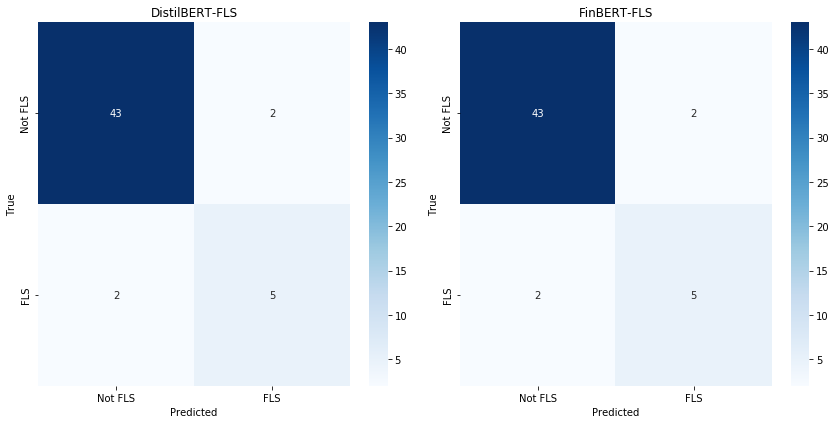

In [23]:
# Create a confusion matrix for each model
distilbert_confmat = create_confusion_matrix(labelsset, pred_distilbert)
finbert_confmat = create_confusion_matrix(labelsset, pred_finbert)

# Redefine the class labels
class_labels = ['Not FLS', 'FLS']

# Create subplots with two confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Create the first confusion matrix subplot
sns.heatmap(distilbert_confmat, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_title('DistilBERT-FLS')

# Create the second confusion matrix subplot
sns.heatmap(finbert_confmat, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
axes[1].set_title('FinBERT-FLS')

# Adjust the layout and spacing
plt.tight_layout()
plt.show()

## Next step

We are now done with classifying the FLS. Subsequently, there are two datasets for further model implementation (performance prediction, in folder **3_performance_prediction**). But before that, it is necessary to prepare these two datasets, making them ready to use. These preparation steps are demonstrated in the folder **2_dataset**.

Additionally, the top important features will be determined in the notebook ``41_explain_fls-classifiers`` in folder **4_interpretation**. This is to give more insights into the crucial features and to see if DistilBERT and FinBERT consider the same words as important. 